# Sequence Classification Using Deep Learning

This example shows how to classify sequence data using a long short-term memory network. 

To train a deep neural network to classify sequence data, you can use an LSTM network. AN LSTM network enables you to input sequence data into a network, and make predictions based on the individual time steps of the sequence data. 

This example uses the [japanese vowels dataset](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). This example trains an LSTM network to recognize the speaker given time series data representing two Japanese vowels spoken in succession. The training data contains time series data for nine speakers. Each sequence has 12 features and varies in length. The data set contains 270 training observations and 370 test observations. 

## Load Sequence Data
First, download the following files from the [Japanese Vowels Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/): ae.test, ae.train, size_ae.test 

Load the Japanese Vowels training data. Xtrain is a cell array containing 270 sequences of dimension 12 of varying length. Y is a categorical vector of labels
"1","2"',...,"9", which corresponds to the 9 speakers. The entries in XTrain are matrices with 12 rows (one row for each feature) and varying number of columns(one column for each time step). 

In [1]:
from numpy.lib.shape_base import column_stack
import numpy as np
# Load the file
# f = open('ae.train','r')
with open('ae.train', 'r') as f: 
  contents = f.read()
  contents = contents.split("\n\n")

# number of time series 
N = len(contents) - 1

Xtrain = [[]] * (N)
for i in range(N):
  cols = contents[i].split('\n')
  Xtrain[i] = []
  for j in range(len(cols)):
    rows = cols[j].split(' ')[0:-1]
    for k in range(len(rows)):
      rows[k] = float(rows[k])
    Xtrain[i].append(rows)
  Xtrain[i] = np.array(Xtrain[i]).T

# Labels should be in blocks of 30
Ytrain = np.zeros((N,9))
for i in range(9):
  for j in range(30):
    Ytrain[30*i + j,i] = 1

# Print the shapes of the first 5 time series, 270 time series total
for i in range(5):
  print("Sample "  + str(i) + " shape: "+ str(np.shape(Xtrain[i]))) 

Sample 0 shape: (12, 20)
Sample 1 shape: (12, 26)
Sample 2 shape: (12, 22)
Sample 3 shape: (12, 20)
Sample 4 shape: (12, 21)


Visualize the first time series in a plot. Each line corresponds to a feature.

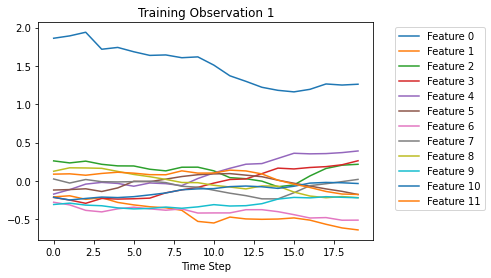

In [2]:
import matplotlib.pyplot as plt

plt.plot(Xtrain[0].T)
plt.xlabel('Time Step')
plt.title('Training Observation 1')
numFeatures = np.shape(Xtrain[0])[0]
leg_string = []
for i in range(numFeatures):
  leg_string.append("Feature " + str(i))
plt.legend(leg_string, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Prepare data for Padding

In the matlab demo, by default, the software splits the training data into mini-batches and pads the sequences so that they have the same length. Too much padding can have a negative impact on the network performance. 

To prevent the training process from adding too much padding, we sorted the training data by sequence length, and chose a mini-batch size so that sequences in a mini-batch have a similar length. The following figure shows the effect of padding sequences before and after sorting data.

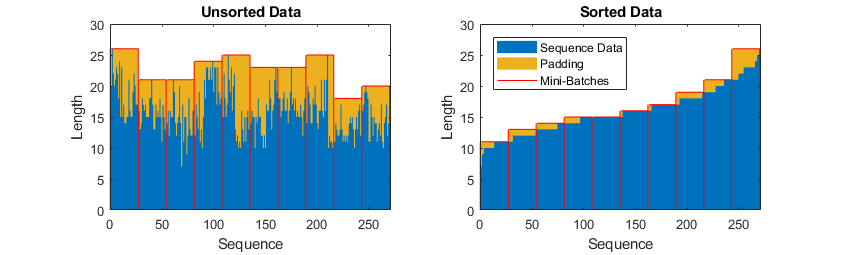

In the python code, we need to pad the data manually, but we can insert a masking layer that can tell the network to ignore the padded sections of the input. This means that we no longer need to worry about sorting and segmenting the data. 

First we identify the maximum length of samples in the dataset to identify how much to pad the data. 

In [3]:
numObservations = len(Xtrain)
seq_len = []
for i in range(numObservations):
  sequence = Xtrain[i]
  seq_len.append(np.shape(Xtrain[i])[1])

max_seq_len = np.max(seq_len)

In [4]:
# Create data generator to pad and format the data.
dimension = 12
special_value = -10
Xpad = np.full((N, max_seq_len, dimension), fill_value=special_value).astype(float)
for s, x in enumerate(Xtrain):
  seq_len = x.shape[1]
  Xpad[s, 0:seq_len, :] = x.T

Ytrain = np.array(Ytrain)
print("X shape: ")
print(np.shape(Xpad))
print("Y shape: ")
print(np.shape(Ytrain))

X shape: 
(270, 26, 12)
Y shape: 
(270, 9)


## Define LSTM Network Architecture

Define the LSTM network architecture. We let our first layer be the masking layer. We specify the input size to be sequences of size 12 (the dimension of the input data), but leave the other dimension as ```None``` so that it can vary during prediction.Then, specify a bidirectional LSTM layer with 100 hidden units and output the last element of the sequence. Finally, specify nine classes by including a fully connected layer of size 9, followed by a softmax layer. 

If you have access to full sequences at prediction time, then you can use a bidirectional LSTM layer in your network. A bidirectional LSTM layer learns from the full sequence at each time step. If you do not have access to the full sequence at prediction time, for example, if you are foecasting values or predicting one time step at a time, then use an LSTM layer instead. 

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Masking
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

dimension = 12
numHiddenUnits = 100
numClasses = 9


# Specify our layer structure
model = Sequential()
#model.add(Embedding(input_size, input_size, input_length=))
model.add(Masking(mask_value=special_value, input_shape=(None, dimension)))
#model.add(keras.Input(shape=(dimension,1)))
model.add(Bidirectional(LSTM(numHiddenUnits)))
model.add(Dense(numClasses, activation='sigmoid'))
model.add(Dense(numClasses, activation='softmax'))


Now, specify the training options. Specify the solver to be 'adam', the gradient threshold to be 1, and the maximum number of epochs to be 100. To match the matlab code, we choose a minibatch size of 27. 

Since the minibatches are small with short sequences, training is better suited for the CPU. 

In [6]:
maxEpochs = 100
miniBatchSize = 27

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 12)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              90400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 9)                 1809      
                                                                 
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
Total params: 92,299
Trainable params: 92,299
Non-trainable params: 0
_________________________________________________________________
None


## Train the LSTM Network

Train the LSTM network with the specified training options.

In [7]:
model.fit(Xpad, Ytrain, epochs=maxEpochs, batch_size=miniBatchSize)

Epoch 1/100
10/10 [==============================] - 6s 37ms/step - loss: 2.2418 - accuracy: 0.1148
Epoch 2/100
10/10 [==============================] - 0s 34ms/step - loss: 2.1073 - accuracy: 0.2185
Epoch 3/100
10/10 [==============================] - 0s 36ms/step - loss: 1.9149 - accuracy: 0.3037
Epoch 4/100
10/10 [==============================] - 0s 36ms/step - loss: 1.7733 - accuracy: 0.3630
Epoch 5/100
10/10 [==============================] - 0s 34ms/step - loss: 1.6672 - accuracy: 0.4481
Epoch 6/100
10/10 [==============================] - 0s 34ms/step - loss: 1.5988 - accuracy: 0.4741
Epoch 7/100
10/10 [==============================] - 0s 36ms/step - loss: 1.5453 - accuracy: 0.4963
Epoch 8/100
10/10 [==============================] - 0s 34ms/step - loss: 1.4879 - accuracy: 0.5222
Epoch 9/100
10/10 [==============================] - 0s 35ms/step - loss: 1.4601 - accuracy: 0.5519
Epoch 10/100
10/10 [==============================] - 0s 36ms/step - loss: 1.4295 - accuracy: 0.5704

## Test the LSTM Network

Load the test set and classify the sequences into speakers. 

Load the Japanese Vowels test data. XTest is a cell array containing 370 sequences of dimension 12 of varying length. YTest is a categorical vector of labels which correspond to the nine speakers.

In [8]:
# Load the file
# f = open('ae.test','r')

with open('ae.test', 'r') as f: 
  contents = f.read()
  contents = contents.split("\n\n")

Ntest = len(contents) - 1
Xtest = [[]] * (Ntest)
for i in range(Ntest):
  rows = contents[i].split('\n')
  Xtest[i] = []
  for j in range(len(rows)):
    cols = rows[j].split(' ')[0:-1]
    for k in range(len(cols)):
      cols[k] = float(cols[k])

    Xtest[i].append(cols)
  

  Xtest[i] = np.array(Xtest[i]).T


# f = open('size_ae.test')
with open('size_ae.test', 'r') as f: 
  contents = f.read()
  contents = contents.split(" ")[0:-1]
  contents = [int(i) for i in contents]

# Labels are specified by sizeae.test
Ytest = np.zeros((Ntest,9))
cc= 0
for i in range(9):
  for j in range(contents[i]):
    Ytest[cc,i] = 1
    cc = cc + 1

In [9]:
numObservations = len(Xtest)
seq_len = []
for i in range(Ntest):
  sequence = Xtest[i]
  seq_len.append(np.shape(Xtest[i])[1])

#max_seq_len = 29
max_seq_len = np.max(seq_len)

We pad the test data to the maximum length of a test sequence. Note that now our sequences are padded to a length of 29 rather than 26.

In [10]:
# Create data generator to pad and format the data.
dimension = 12
special_value = -10
XPad2 = np.full((Ntest, max_seq_len, dimension), fill_value=special_value).astype(float)
for s, x in enumerate(Xtest):
  seq_len = x.shape[1]
  XPad2[s, 0:seq_len, :] = x.T

Ytest = np.array(Ytest)
print(np.shape(XPad2))
print(np.shape(Ytest))

(370, 29, 12)
(370, 9)


Classify the test data.

In [11]:
output = model.predict(XPad2)
classified = np.argmax(output,axis=1)
yhat = np.zeros((Ntest,9))
for i in range(len(classified)):
  yhat[i,classified[i]] = 1

Calculate the classification accuracy of the predictions.

In [12]:
acc = np.sum(np.multiply(yhat, Ytest))/Ntest
print("Accuracy: " + str(acc))

Accuracy: 0.9594594594594594


Alternatively, We can use evaluate to compute the accuracy and loss on the test set.

In [13]:
loss, acc2 = model.evaluate(XPad2,Ytest)
print("Accuracy: " + str(acc2))

12/12 [==============================] - 3s 13ms/step - loss: 0.3801 - accuracy: 0.9595
Accuracy: 0.9594594836235046


More information about LSTM training in keras can be found at:

https://adventuresinmachinelearning.com/keras-lstm-tutorial/

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/